[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is similar to [linear regression](/blog/ml-linear-regression/), but instead of predicting a continuous output, classifies training examples by a set of categories or labels.  For example, linear regression on a set of social and economic data might be used to predict a person's income, but logistic regression could be used to predict whether that person was married, had children, or had ever been arrested.  In a basic sense, logistic regression only answers questions that have yes / no answers, or questions that can be answered with a 1 or 0.  However, it can easily be [extended](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to problems where there are a larger set of categories.

Here, I'm using the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI. It maps thirteen continuous variables representing chemical contents of a wine to three labels, each a different winery in Italy.

# Loading and Plotting Data
 
Initially, I'm only using two features from the data set: alcohol and ash.  The labels are supplied as an array of data with values from `1` to `3`, but at first, I only want a simple regression problem with a yes or no answer.  

To do this, I first filter the data set, reducing it to only include wines with labels `1` or `2`.  Then, I use the scikit-learn `label_binarize` function, which takes an $m$-length list with $n$ possible values (two, in this case), and converts it to an $m \times n$ matrix, where each column represents one label with a value of `1`, and all others with a value of `0`.  I choose the first column, though the second would be equally valid here, just with the labels reversed.

I've provided a small example of `label_binarize` below, shuffling the whole input data set first (the examples are sorted by winery), and then selecting the first ten.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

reduced = data[data['class'] <= 2]
#X = reduced.as_matrix(columns=['alcohol', 'ash'])
X = reduced[['alcohol', 'ash']].values
y = label_binarize(reduced['class'].values, classes=[1, 2])[:,0]

example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, classes=list(set(example)))
print('binarized:', example)
print('1s vs all:', example[:,0])

original: [3 2 2 2 1 2 3 1 3 3]
binarized: [[0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
1s vs all: [0 0 0 0 1 0 0 1 0 0]


-Este código carga datos de vinos y se queda solo con los de tipo 1 y 2.
Toma dos medidas (alcohol y cenizas) para usarlas después y convierte los tipos en 0 y 1 para que la computadora entienda.
Al final muestra un ejemplo: coge 10 tipos al azar, los mezcla y enseña cómo los convierte en 0 y 1 de forma automática.

I also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 25%) to sample randomly from the data set and partition away for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


-Este código separa automáticamente tus datos en conjunto de entrenamiento (75 %) y conjunto de prueba (25 %) de forma aleatoria, que es el paso estándar antes de entrenar cualquier modelo de machine learning.

Because I'm going to be drawing a lot of data plots, I define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

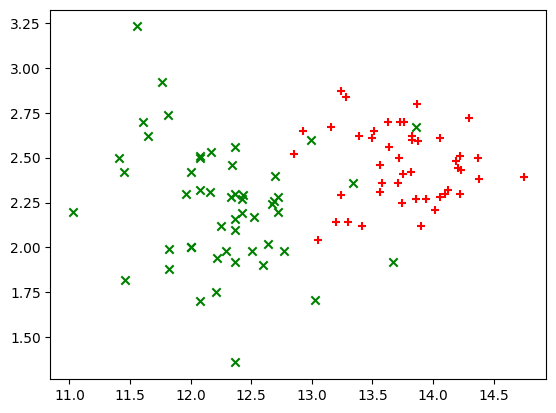

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

Este código define y ejecuta una función que genera un scatter plot 2D de los datos de entrenamiento (X_train) usando las dos características seleccionadas (alcohol en el eje X, ash en el eje Y), coloreando y marcando diferentemente cada clase según su etiqueta binaria en y_train (0 o 1).

There's a fairly obvious area near the center of the plot where a line could divide the two colors of points with a small amount of error.

# Simple Logistic Regression

To implement logistic regression, I need a hypothesis function $h_\theta(x)$, a cost function $J(\theta)$, and a gradient function that computes the partial derivatives of $J(\theta)$.

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between 0 and 1, and produces a value that can be interpreted as a probability.  This value can also be a yes / no answer with a cross-over, or decision boundary, at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [ ]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

-El fragmento de código implementa las funciones esenciales de una regresión logística binaria desde cero utilizando únicamente NumPy. La función sigmoid calcula la sigmoide estándar para transformar cualquier valor real en el intervalo (0,1).Estas tres funciones constituyen la base matemática completa necesaria para entrenar un modelo de regresión logística mediante cualquier algoritmo de optimización basado en gradiente (descenso de gradiente, BFGS, etc.) sobre los datos preparados previamente.

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the matrix operations work correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below, and with TensorFlow.  The indexing syntax can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing a gradient descent, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

In [ ]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [72.1250648  -4.96387368 -3.0874307 ]


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   1.66077692E-03
tnc: fscale = 24.5383
    1    3  6.931065735846907E-01   1.90691853E-03
tnc: stepmx = 1000
    2    5  4.818389882982752E-01   3.13788964E-03
    3    7  4.543669236870654E-01   1.52265554E+00
tnc: fscale = 0.8104
    4    9  4.336859328255182E-01   6.76050832E-04
tnc: fscale = 38.4601
    5   11  4.336202493661249E-01   4.14978604E-03
    6   13  3.786646260004704E-01   1.67643644E-02
    7   15  3.748442974755624E-01   1.26230687E-01
    8   17  3.611386429502178E-01   2.17941505E-02
    9   19  3.598884445396887E-01   9.48251629E-03
   10   21  3.584725846582344E-01   1.18265182E-01
   11   26  2.943727965853128E-01   3.76119937E-02
   12   28  2.933350987219769E-01   2.94549894E-03
   13   32  2.767151032028906E-01   4.33598441E-02
   14   34  2.758293804756853E-01   2.24191077E-03
   15   36  2.705420926542681E-01   6.13131916E-03
   16   38  2.701798361150627E-01   2.80828375E-03
   17   

-El fragmento define la función train que entrena un modelo de regresión logística binaria desde cero sobre los datos de entrada X e y. Primero, inserta una columna de unos en la posición 0 de X (término de bias o intercepto), convirtiendo así la matriz de características en su forma aumentada $\tilde{X} \in \mathbb{R}^{m \times (n+1)}$. A continuación, inicializa el vector de parámetros $\theta$ en cero y utiliza el algoritmo de optimización fmin_tnc (Truncated Newton Constrained) de SciPy, que minimiza la función de costo cost empleando el gradiente exacto proporcionado por la función gradient. Los argumentos args=(X, y) pasan los datos aumentados y las etiquetas al par costo/gradiente. El método devuelve el vector de parámetros óptimos $\theta^*$ que minimiza la entropía cruzada binaria sobre el conjunto de entrenamiento. Finalmente, la llamada theta = train(X_train, y_train) entrena el modelo con los datos de entrenamiento y almacena los parámetros aprendidos, que luego se imprimen. Este procedimiento constituye una implementación completa y vectorizada de regresión logística mediante descenso de gradiente truncado de Newton, sin depender de scikit-learn.

# Decision Boundaries and Evaluation


I can evaluate the results of the optimization visually and statistically, but I also need one more function: `predict`, which takes an array of examples `X` and learned parameter values `theta` as inputs and returns the predicted label for each.  Here too, 1s must be prepended to the inputs, and I return an integer value representing whether the result of the `sigmoid` hypothesis function is equal to or greater than 0.5.

To test the results of those predictions, Scikit-learn provides three functions to calculate [accuracy, precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).  The test data from earlier is used here, so the results represent the performance of the classifier on unseen data.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)
predictions = np.asarray(predictions).flatten()
print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9090909090909091
precision: 0.9107142857142857
recall: 0.898076923076923


-El programa coge datos de vinos, usa solo alcohol y cenizas para separar dos tipos, dibuja los puntos, crea y entrena un modelo matemático sencillo desde cero, y al final dice qué tan bien acierta al clasificar vinos nuevos. Es un ejemplo básico de clasificación automática con una computadora.

-El código carga el dataset de vinos, selecciona solo las clases 1 y 2, y usa únicamente las variables “alcohol” y “ash” para realizar una clasificación binaria mediante regresión logística implementada completamente desde cero. Divide los datos en entrenamiento y prueba, los visualiza en un gráfico 2D, define la sigmoide, el costo de entropía cruzada y su gradiente de forma vectorizada, entrena el modelo optimizando los parámetros con el método Truncated Newton, predice sobre el conjunto de prueba aplicando umbral 0.5 y, finalmente, muestra accuracy, precision y recall. En resumen, es un ejemplo educativo completo de regresión logística manual con NumPy y SciPy.

It's much more interesting to review the results visually, at least while the number of features is limited to two.  To do this, I need to plot the input points again, then overlay the decision boundary on top.  I tried several approaches for this in Matplotlib, and found that an unfilled countour plot gave me the best results.  This can also be done by manually calculating the function to plot, or using a filled contour plot that shades over the actual areas, but doing the math by hand is tedious, and the colormaps for filled contour plots leave a lot to be desired visually.

Below, I define a function `plot_boundary` that takes $n \times 2$ matrix of feature values $(x_0, x_1)$ and a prediction function, then builds a mesh grid of $(x, y)$ points corresponding to possible $(x_0, x_1)$ values within the input range.  After running the prediction function on all of them, the result is an $(x, y, z)$ point in space.  Because the result isn't continuous and flips directly from 0 to 1, there's only one contour that can be drawn on the plot: the decision boundary.

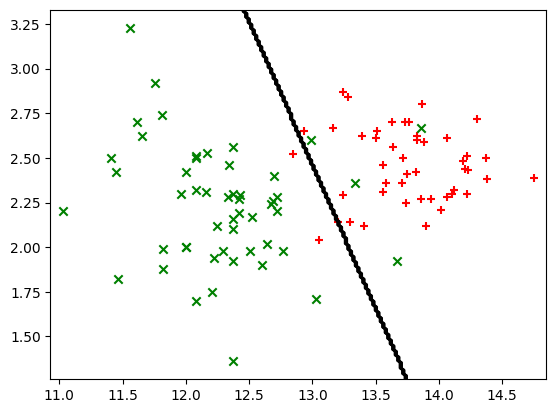

In [ ]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))


Este código dibuja la línea que el modelo aprendió para separar los dos tipos de vino.
Crea una cuadrícula de puntos en el gráfico, usa el modelo para predecir qué lado pertenece a cada punto y traza una línea negra donde el modelo dice “aquí cambia de un tipo al otro”.
